In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import date,timedelta

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [26]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping


In [96]:
path= 'bus_running_times_feature_added_all.csv'
data = pd.read_csv(path)

data = data.drop(data[data['run_time_in_seconds'] > 2000].index )
data = data.loc[(data['time_of_day']>= 6) & (data['time_of_day']<19)]
data = data[data['direction']==1]

PrepData


In [97]:
data['DateTime'] = pd.to_datetime(data['date'] + ' ' + data['start_time'])

ref_freq = '15min'
ix = pd.DatetimeIndex(pd.to_datetime(data['DateTime'])).floor(ref_freq)

data["DateTimeRef"] = ix

data['DayOfWeek'] = pd.to_datetime(data['date']).dt.weekday
data["DowTimeRef"] = pd.to_datetime((data['DayOfWeek'].values ) * 24 * 60 * 60 + ix.hour * 60 * 60 + ix.minute * 60, unit = 's')

data

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,month,temp,precip,windspeed,conditions,dt(n-1),DateTime,DateTimeRef,DayOfWeek,DowTimeRef
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,...,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2021-10-01 06:39:49,2021-10-01 06:30:00,4,1970-01-05 06:30:00
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,...,10.0,20.0,0.0,6.1,Partially cloudy,74.0,2021-10-01 06:42:12,2021-10-01 06:30:00,4,1970-01-05 06:30:00
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,...,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2021-10-01 06:45:42,2021-10-01 06:45:00,4,1970-01-05 06:45:00
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,...,10.0,20.0,0.0,6.1,Partially cloudy,6.0,2021-10-01 06:54:04,2021-10-01 06:45:00,4,1970-01-05 06:45:00
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,...,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2021-10-01 06:57:19,2021-10-01 06:45:00,4,1970-01-05 06:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,1.1000,...,11.0,20.5,0.0,8.3,Overcast,15.0,2022-11-01 18:47:53,2022-11-01 18:45:00,1,1970-01-02 18:45:00
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,1.3100,...,11.0,20.5,0.0,8.3,Overcast,7.0,2022-11-01 18:50:15,2022-11-01 18:45:00,1,1970-01-02 18:45:00
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,1.1500,...,11.0,20.5,0.0,8.3,Overcast,11.0,2022-11-01 18:52:50,2022-11-01 18:45:00,1,1970-01-02 18:45:00
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,0.8900,...,11.0,20.5,0.0,8.3,Overcast,13.0,2022-11-01 18:55:14,2022-11-01 18:45:00,1,1970-01-02 18:45:00


In [50]:
def datetime_index_generator(start_date,end_date,start_time,end_time,freq):
  date_range = pd.date_range(start_date, end_date, freq='D')
  date_list = [i.strftime('%Y-%m-%d') for i in date_range]
  datetime_series = pd.Series()

  for date in date_list:
    begin_timestamp = pd.to_datetime(date + ' ' + start_time )
    end_timestamp = pd.to_datetime(date + ' ' + end_time )
    daily_time_range = pd.Series(index = pd.date_range(begin_timestamp,end_timestamp,freq = freq))

    datetime_series = pd.concat([datetime_series,daily_time_range ]).sort_index()

  return datetime_series

Fit_scale

In [73]:
def fit_scale(data, ref_freq = '15min'):
  means = { }
  scales = { }
  low = { }
  upr = { }

  grouping = data[data['run_time_in_seconds'].notnull()].groupby('segment', sort = False)

  for segment, data_link in grouping:
        # Fit outlier bounds using MAD
        median = data_link.groupby('DowTimeRef')['run_time_in_seconds'].median()
        error = pd.concat([data_link['DowTimeRef'], np.abs(data_link['run_time_in_seconds'] - median[data_link['DowTimeRef']].values)], axis = 1)
        mad = 1.4826 * error.groupby('DowTimeRef')['run_time_in_seconds'].median()
        
        _low = median - 3 * mad
        _upr = median + 3 * mad
        mask = (_low[data_link['DowTimeRef']].values < data_link['run_time_in_seconds']) & (data_link['run_time_in_seconds'] < _upr[data_link['DowTimeRef']].values)
        data_link_no = data_link[mask]
        
        _mean = data_link_no.groupby('DowTimeRef')["run_time_in_seconds"].mean()
        means[segment] = _mean
        low[segment] = _low
        upr[segment] = _upr
        scales[segment] = data_link_no['run_time_in_seconds'].std()

  #ix = pd.date_range('1970-01-01', '1970-01-08', freq = ref_freq, closed = 'left')
  index_series = datetime_index_generator('1970-01-01','1970-01-07','06:00:00','19:00:00',freq='15min')
  ix = index_series.index
  means_df = pd.DataFrame(data = means, index = ix).interpolate()
  low_df = pd.DataFrame(data = low, index = ix).interpolate()
  upr_df = pd.DataFrame(data = upr, index = ix).interpolate()

  means_df = means_df.fillna(method='pad').fillna(method='bfill')
  low_df = low_df.fillna(method='pad').fillna(method='bfill')
  upr_df = upr_df.fillna(method='pad').fillna(method='bfill')
  return means_df, scales, low_df, upr_df


Time series index generator

In [98]:
s1 = datetime_index_generator('2021-10-01','2022-02-28','06:00:00','19:00:00',freq='15min')
s2 = datetime_index_generator('2022-07-01','2022-11-01','06:00:00','19:00:00',freq='15min')

s = pd.concat([s1,s2]).sort_index()

datetime_index = s.index

datetime_index

C:\Users\shang\AppData\Local\Temp\ipykernel_42228\1703285400.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  datetime_series = pd.concat([datetime_series,daily_time_range ]).sort_index()
C:\Users\shang\AppData\Local\Temp\ipykernel_42228\1703285400.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  datetime_series = pd.concat([datetime_series,daily_time_range ]).sort_index()


DatetimeIndex(['2021-10-01 06:00:00', '2021-10-01 06:15:00',
               '2021-10-01 06:30:00', '2021-10-01 06:45:00',
               '2021-10-01 07:00:00', '2021-10-01 07:15:00',
               '2021-10-01 07:30:00', '2021-10-01 07:45:00',
               '2021-10-01 08:00:00', '2021-10-01 08:15:00',
               ...
               '2022-11-01 16:45:00', '2022-11-01 17:00:00',
               '2022-11-01 17:15:00', '2022-11-01 17:30:00',
               '2022-11-01 17:45:00', '2022-11-01 18:00:00',
               '2022-11-01 18:15:00', '2022-11-01 18:30:00',
               '2022-11-01 18:45:00', '2022-11-01 19:00:00'],
              dtype='datetime64[ns]', length=14575, freq=None)

Outliers

In [99]:
def remove_outliers(data, low, upr):
    _low = low.lookup(data['DowTimeRef'], data['segment'])
    _upr = upr.lookup(data['DowTimeRef'], data['segment'])
    mask = ((_low < data['run_time_in_seconds']) & (data['run_time_in_seconds'] < _upr))
    data = data.loc[mask].copy()
    return data, (~mask).sum()

Transform

In [14]:
def transform(data, means_df, scales,datetime_index, freq = '15min'):
  tss = { }
  ws = { }
  removed_mean = { }
  removed_scale = { }
  ks = []
  
  for k, v in data.groupby('segment', sort = False):
        # Link Data Time Indexed
        link_time_ix = pd.DatetimeIndex(pd.to_datetime(v['DateTime']))    
        link_time_ixd = v.set_index(link_time_ix)
        
        # Link Reference Data Index
        ix_ref = link_time_ixd['DowTimeRef']  

        link_travel_time_k = link_time_ixd['run_time_in_seconds'].resample(freq).mean()
        link_travel_time_k = link_travel_time_k[link_travel_time_k.index.isin(datetime_index)]
        
        removed_mean[k] = pd.Series(data = means_df.loc[ix_ref, k].values, index = link_time_ix).resample(freq).mean()
        removed_mean[k] = removed_mean[k][removed_mean[k].index.isin(datetime_index)]

        removed_scale[k] = pd.Series(data = np.repeat(scales[k], link_travel_time_k.shape[0]), index = link_travel_time_k.index)
        tss[k] = (link_travel_time_k - removed_mean[k].values) / removed_scale[k].values
        
        ws[k] = link_time_ixd['run_time_in_seconds'].resample(freq).count()
        ws[k] = ws[k][ws[k].index.isin(datetime_index)]

        ks.append(k)

  ts = pd.DataFrame(data = tss).fillna(method='pad').fillna(0) # Link Travel Time Time Series
  df_removed_mean = pd.DataFrame(data = removed_mean, index = ts.index).fillna(method='pad').fillna(method='bfill') # Removed Mean from Link Travel Time
  df_removed_scale = pd.DataFrame(data = removed_scale, index = ts.index).fillna(method='pad').fillna(method='bfill')
  w = pd.DataFrame(data = ws).fillna(0) # Link Travel Time Weights, e.g. number of measurements

  return (ts.index, ts.values, df_removed_mean.values, df_removed_scale.values, w.values, ks)


In [15]:
def roll(ix, ts, removed_mean, removed_scale, w, lags, preds):
    X = np.stack([np.roll(ts, i, axis = 0) for i in range(lags, 0, -1)], axis = 1)[lags:-preds,]
    Y = np.stack([np.roll(ts, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
    Y_ix = ix[lags:-preds]
    Y_mean = np.stack([np.roll(removed_mean, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
    Y_scale = np.stack([np.roll(removed_scale, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
    w_y = np.stack([np.roll(w, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]

    return X, Y, Y_ix, Y_mean, Y_scale, w_y

Model Definition

In [16]:
def build_model(input_timesteps, output_timesteps, num_links):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.2, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.1, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_links, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.1, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

In [110]:
def build_model(input_timesteps, output_timesteps, num_links):
    model = Sequential()
    #model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.2, name = 'dropout_1'))
    #model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_links, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.1, name = 'dropout_2'))

    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

In [18]:
def info(msg):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " " + msg)

Load Data

In [100]:
lags = 4 * 13
preds = 3

In [101]:
n = len(data)

Train and Test

In [102]:
data_train = data[data['week_no'] < 36]
data_test = data[36 <= data['week_no']]
n_train = len(data_train)
n_test = len(data_test)
info('- Train size : {:>8} ({:.2f}%) '.format(n_train, 100. * n_train / n))
info('- Test size  : {:>8} ({:.2f}%) '.format(n_test, 100. * n_test / n))

2023-12-29 09:30:38 - Train size :    78957 (80.71%) 
2023-12-29 09:30:38 - Test size  :    18876 (19.29%) 


In [103]:
(means, scales, low, upr) = fit_scale(data_train)

C:\Users\shang\AppData\Local\Temp\ipykernel_42228\1703285400.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  datetime_series = pd.concat([datetime_series,daily_time_range ]).sort_index()
C:\Users\shang\AppData\Local\Temp\ipykernel_42228\66091606.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  means_df = means_df.fillna(method='pad').fillna(method='bfill')
C:\Users\shang\AppData\Local\Temp\ipykernel_42228\66091606.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  low_df = low_df.fillna(method='pad').fillna(method='bfill')
C:\Users\shang\AppData\Local\Temp\ipykernel_42228\660916

In [104]:
data_train_no , no_removed =  remove_outliers(data_train,low,upr)

AttributeError: 'DataFrame' object has no attribute 'lookup'

In [76]:
no_removed

NameError: name 'no_removed' is not defined

In [77]:
data_test_no , no_removed =  remove_outliers(data_test,low,upr)
no_removed

AttributeError: 'DataFrame' object has no attribute 'lookup'

In [105]:
data_train_no = data_train
data_test_no = data_test

In [107]:
ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lns_train = transform(data_train_no, means, scales,datetime_index)
ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lns_test = transform(data_test_no, means, scales,datetime_index)

#Create rolling window tensor
X_train, Y_train, Y_ix_train, Y_rm_mean_train, Y_scale_train, Y_w_train = roll(ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lags, preds)
X_test, Y_test, Y_ix_test, Y_rm_mean_test, Y_scale_test, Y_w_test = roll(ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lags, preds)

X_train = X_train[:,:,:,np.newaxis,np.newaxis]
Y_train = Y_train[:,:,:,np.newaxis,np.newaxis]
X_test = X_test[:,:,:,np.newaxis,np.newaxis]
Y_test = Y_test[:,:,:,np.newaxis,np.newaxis]

info('- X_train shape : {:>20}    X_test shape : {:>20}'.format(str(X_train.shape), str(X_test.shape)))
info('- Y_train shape : {:>20}    Y_test shape : {:>20}'.format(str(Y_train.shape), str(Y_test.shape)))


C:\Users\shang\AppData\Local\Temp\ipykernel_42228\196139629.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = pd.DataFrame(data = tss).fillna(method='pad').fillna(0) # Link Travel Time Time Series
C:\Users\shang\AppData\Local\Temp\ipykernel_42228\196139629.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_removed_mean = pd.DataFrame(data = removed_mean, index = ts.index).fillna(method='pad').fillna(method='bfill') # Removed Mean from Link Travel Time
C:\Users\shang\AppData\Local\Temp\ipykernel_42228\196139629.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_removed_scale = pd.DataFrame(data = removed_scale, index = ts.index).fillna(method='pad').fillna(method='bfill')
C:\Users\shang\AppData\Loc

2023-12-29 09:32:29 - X_train shape : (12185, 52, 15, 1, 1)    X_test shape : (2275, 52, 15, 1, 1)
2023-12-29 09:32:29 - Y_train shape : (12185, 3, 15, 1, 1)    Y_test shape :  (2275, 3, 15, 1, 1)


In [111]:
global_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

model = build_model(lags, preds, len(lns_train))

# Train
history = model.fit(X_train, Y_train,
                    batch_size = 32, epochs = 1,
                    shuffle = False, validation_data = (X_test, Y_test),
                    verbose = 2, callbacks = [early_stopping])
model.save('models/ConvLSTM_3x15min_10x64-5x64-10x64-5x64_Comparison.h5') 

Y_true = Y_test.squeeze() * Y_scale_test + Y_rm_mean_test
Y_naive = Y_rm_mean_test
Y_pred = model.predict(X_test).squeeze() * Y_scale_test + Y_rm_mean_test

Y_true_total = np.sum(Y_true * Y_w_test, axis = 2).squeeze()
Y_naive_total = np.sum(Y_naive * Y_w_test, axis = 2).squeeze()
Y_pred_total = np.sum(Y_pred * Y_w_test, axis = 2).squeeze()
    
for t in range(preds):
    mask = Y_true_total[:,t] > 0
    Y_true_total_t = Y_true_total[mask, t] / 60
    Y_naive_total_t = Y_naive_total[mask, t] / 60
    Y_pred_total_t = Y_pred_total[mask, t] / 60  

    error_naive_total_t = (Y_naive_total_t - Y_true_total_t)
    error_lstm_total_t = (Y_pred_total_t - Y_true_total_t)

    mae_ha = np.mean(np.abs(error_naive_total_t))
    rmse_ha = np.sqrt(np.mean((error_naive_total_t)**2))
    mape_ha = np.mean(np.abs(error_naive_total_t) / Y_true_total_t) * 100

    mae_lstm = np.mean(np.abs(error_lstm_total_t))
    rmse_lstm = np.sqrt(np.mean((error_lstm_total_t)**2))
    mape_lstm = np.mean(np.abs(error_lstm_total_t) / Y_true_total_t) * 100

    info("- t + %d - HA       - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_ha, rmse_ha, mape_ha))
    info("- t + %d - ConvLSTM - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm, rmse_lstm, mape_lstm))
    info("- t + %d - *        - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm - mae_ha, rmse_lstm - rmse_ha, mape_lstm - mape_ha))

ValueError: in user code:

    File "C:\Users\shang\gitrepo\Incremental-Online-Learning-for-BAT-Prediction\venv\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\shang\gitrepo\Incremental-Online-Learning-for-BAT-Prediction\venv\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shang\gitrepo\Incremental-Online-Learning-for-BAT-Prediction\venv\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\shang\gitrepo\Incremental-Online-Learning-for-BAT-Prediction\venv\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\shang\gitrepo\Incremental-Online-Learning-for-BAT-Prediction\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\shang\gitrepo\Incremental-Online-Learning-for-BAT-Prediction\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py", line 118, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer 'reshape_2' (type Reshape).
    
    total size of new array must be unchanged, input_shape = [3, 49920], output_shape = [3, 15, 1, 64]
    
    Call arguments received by layer 'reshape_2' (type Reshape):
      • inputs=tf.Tensor(shape=(None, 3, 49920), dtype=float32)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormaliz  (None, 52, 15, 1, 1)     4         
 ation)                                                          
                                                                 
 conv_lstm_1 (ConvLSTM2D)    (None, 52, 15, 1, 64)     166656    
                                                                 
 dropout_1 (Dropout)         (None, 52, 15, 1, 64)     0         
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 52, 15, 1, 64)    256       
 ation)                                                          
                                                                 
 conv_lstm_2 (ConvLSTM2D)    (None, 15, 1, 64)         164096    
                                                                 
 dropout_2 (Dropout)         (None, 15, 1, 64)         0

In [ ]:
!pip install neuralplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from neuralplot import ModelPlot

In [ ]:
%matplotlib inline 

ValueError: ignored

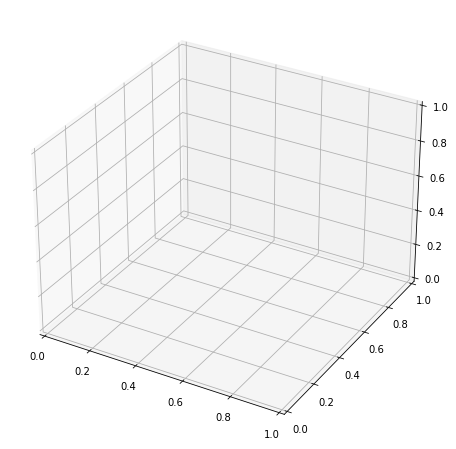

In [ ]:
modelplot = ModelPlot(model=model, grid=False, connection=True, linewidth=0.1)
modelplot.show()

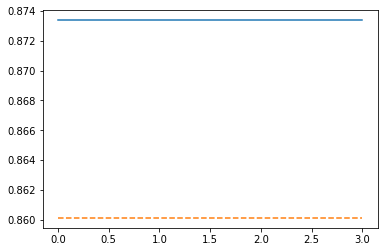

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle = '--')

In [ ]:
output = pd.DataFrame(data = Y_pred[:,0,:], index = Y_ix_test, columns = lns_test)

In [ ]:
output['Datetime']=output.index

In [ ]:
output

,1.0,3.0,4.0,5.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,2.0,6.0,Datetime
DateTime,,,,,,,,,,,,,,,,
2022-09-20 06:15:00,83.916667,412.090909,230.647059,146.333333,46.750000,80.300,28.222222,158.444444,139.000000,155.611111,128.882353,101.869565,337.150000,233.923077,217.733333,2022-09-20 06:15:00
2022-09-20 06:30:00,83.916667,412.090909,195.272727,121.923077,46.750000,80.300,28.222222,158.444444,139.000000,155.611111,128.882353,101.869565,337.150000,233.923077,276.052632,2022-09-20 06:30:00
2022-09-20 06:45:00,83.916667,412.090909,195.272727,121.923077,40.200000,80.500,24.600000,192.500000,241.000000,167.285714,128.882353,101.869565,337.150000,233.923077,276.052632,2022-09-20 06:45:00
2022-09-20 07:00:00,97.000000,703.814815,195.272727,121.923077,40.200000,80.500,24.600000,192.500000,241.000000,167.285714,170.384615,105.000000,408.857143,302.880000,276.052632,2022-09-20 07:00:00
2022-09-20 07:15:00,98.700000,564.071429,197.958333,121.916667,40.200000,80.500,24.600000,192.500000,241.000000,167.285714,170.384615,105.000000,408.857143,314.272727,235.080000,2022-09-20 07:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01 17:00:00,93.941176,437.615385,232.250000,143.000000,44.571429,82.875,27.294118,159.928571,173.500000,163.153846,154.928571,104.500000,328.100000,247.937500,230.333333,2022-11-01 17:00:00
2022-11-01 17:15:00,93.941176,437.615385,232.250000,142.941176,44.571429,82.875,31.230769,164.142857,139.230769,155.333333,141.437500,106.578947,328.100000,247.937500,230.615385,2022-11-01 17:15:00
2022-11-01 17:30:00,93.941176,437.615385,232.250000,142.941176,44.571429,82.875,31.230769,164.142857,139.692308,165.066667,144.750000,106.277778,350.714286,247.937500,230.615385,2022-11-01 17:30:00


In [ ]:
def download_csv(data,filename):
  filename= filename + '.csv'
  data.to_csv(filename, encoding = 'utf-8-sig',index= False)
  files.download(filename)

In [ ]:
download_csv(output,'cnn_running_1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
means

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,Datetime
1970-01-01 06:00:00,91.727273,228.800000,397.772727,216.800000,123.900000,230.166667,39.600000,83.454545,24.666667,179.777778,199.833333,131.000000,160.500000,102.545455,334.250000,1970-01-01 06:00:00
1970-01-01 06:15:00,86.705882,220.800000,397.772727,216.800000,123.900000,230.166667,39.600000,83.454545,24.666667,179.777778,199.833333,131.000000,160.500000,102.545455,334.250000,1970-01-01 06:15:00
1970-01-01 06:30:00,90.500000,236.000000,435.866667,191.117647,107.384615,230.166667,39.600000,83.454545,24.666667,179.777778,199.833333,131.000000,160.500000,102.545455,334.250000,1970-01-01 06:30:00
1970-01-01 06:45:00,96.550000,260.952381,546.782609,195.666667,108.500000,223.533333,45.761905,82.450000,25.250000,166.200000,225.176471,169.166667,161.166667,102.545455,334.250000,1970-01-01 06:45:00
1970-01-01 07:00:00,93.750000,298.761905,722.916667,206.944444,120.350000,213.631579,36.947368,73.210526,26.421053,172.687500,219.588235,177.809524,154.750000,99.125000,347.812500,1970-01-01 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-07 17:45:00,116.142857,209.428571,402.222222,205.100000,142.625000,194.625000,50.200000,79.000000,23.100000,156.909091,145.900000,154.875000,152.777778,102.933333,322.846154,1970-01-07 17:45:00
1970-01-07 18:00:00,110.000000,178.000000,429.700000,220.166667,138.666667,195.400000,44.500000,81.750000,20.777778,151.300000,127.888889,159.636364,142.800000,109.750000,330.642857,1970-01-07 18:00:00
1970-01-07 18:15:00,100.625000,187.500000,407.666667,224.444444,139.818182,184.444444,46.400000,71.600000,26.375000,151.888889,135.727273,147.222222,123.125000,92.714286,312.300000,1970-01-07 18:15:00
1970-01-07 18:30:00,102.250000,217.500000,407.600000,231.875000,125.200000,213.800000,49.500000,80.600000,26.166667,168.125000,123.600000,153.375000,126.600000,93.750000,334.888889,1970-01-07 18:30:00


In [ ]:
means['Datetime']=means.index

In [ ]:
download_csv(means,'HA')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Out of Fold Training

In [ ]:
global_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

bootstrap_size_pct = 0.80
test_window_pct = 0.05
max_iter = 4

lags = 4 * 8
preds = 3

hist = []
for i in range(max_iter):

    info("Current window: " + str(i))
    
    # Devide into test and train
    data_train = data[:int((bootstrap_size_pct + i * test_window_pct) * n)]
    data_test = data[int((bootstrap_size_pct + i * test_window_pct) * n):int((bootstrap_size_pct + (i + 1) * test_window_pct) * n)]
    n_train = len(data_train)
    n_test = len(data_test)
    info('- Train size : {:>8} ({:.2f}%) '.format(n_train, 100. * n_train / n))
    info('- Test size  : {:>8} ({:.2f}%) '.format(n_test, 100. * n_test / n))
    
    # Mean center and scale
    (means, scales, low, upr) = fit_scale(data_train)
    assert means.shape == (4 * 24 * 7, 32)
    assert len(scales) == 32
    assert low.shape == (4 * 24 * 7, 32)
    assert upr.shape == (4 * 24 * 7, 32)
    
    data_train_no = data_train
    data_test_no = data_test
    #data_train_no, n_outliers = remove_outliers(data_train, low, upr)
    #info('- Removed {0} outliers ({1:.2f}%) from train'.format(n_outliers, 100.0 * n_outliers / len(data_train)))
    #data_test_no, n_outliers = remove_outliers(data_test, low, upr)
    #info('- Removed {0} outliers ({1:.2f}%) from test'.format(n_outliers, 100.0 * n_outliers / len(data_test)))
    
    ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lns_train = transform(data_train_no, means, scales)
    ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lns_test = transform(data_test_no, means, scales)

NameError: ignored

In [ ]:
X_train, Y_train, Y_ix_train, Y_rm_mean_train, Y_scale_train, Y_w_train = roll(ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lags, preds)
X_test, Y_test, Y_ix_test, Y_rm_mean_test, Y_scale_test, Y_w_test = roll(ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lags, preds)
X_train = X_train[:,:,:,np.newaxis,np.newaxis]
Y_train = Y_train[:,:,:,np.newaxis,np.newaxis]
X_test = X_test[:,:,:,np.newaxis,np.newaxis]
Y_test = Y_test[:,:,:,np.newaxis,np.newaxis]
    
info('- X_train shape : {:>20}    X_test shape : {:>20}'.format(X_train.shape, X_test.shape))
info('- Y_train shape : {:>20}    Y_test shape : {:>20}'.format(Y_train.shape, Y_test.shape))
    
model = build_model(lags, preds, len(lns_train))
    
    # Train
history = model.fit(X_train, Y_train,
                        batch_size = 128, epochs = 30,
                        shuffle = False, validation_data = (X_test, Y_test),
                        verbose = 2) #, callbacks = [csv_logger, early_stopping])
hist.append(history)
model.save('models/ConvLSTM_3x15min_10x64-5x64-10x64-5x64_' + str(i) + '.h5') 

Y_true = Y_test.squeeze() * Y_scale_test + Y_rm_mean_test
Y_naive = Y_rm_mean_test
Y_pred = model.predict(X_test).squeeze() * Y_scale_test + Y_rm_mean_test
        
Y_true_total = np.sum(Y_true * Y_w_test, axis = 2).squeeze()
Y_naive_total = np.sum(Y_naive * Y_w_test, axis = 2).squeeze()
Y_pred_total = np.sum(Y_pred * Y_w_test, axis = 2).squeeze()